# 2D Plumb wave activity flux


![Image Name](https://cdn.kesci.com/upload/image/qxv2d5gu8i.png?imageView2/0/w/960/h/960)

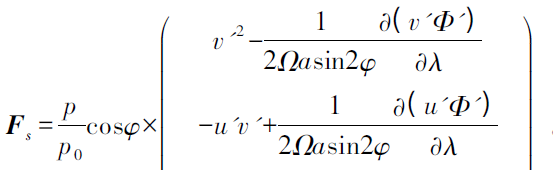

上标'`'表示纬圈平均和纬向偏差 ‘-’为纬向平均; 

ψ纬度 ; λ经度 ; φ位势 ; 

f=2Ωsinψ科⽒参数 ; a地球半径6400000 ; Ω地球⾃转速率7.292e-5; 

p0=1000 hPa; 

## Example (2014.11 @ 250 hPa)


![Image Name](https://cdn.kesci.com/upload/image/qxv2dhhdkv.png?imageView2/0/w/960/h/960)

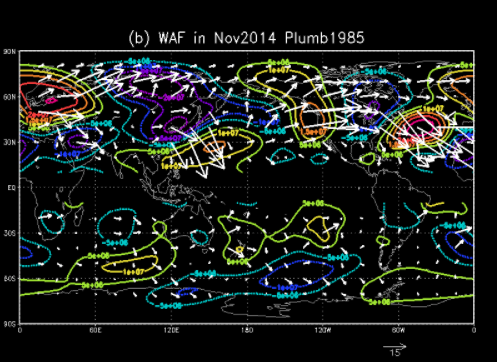

wget ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/uwnd.mon.mean.nc

wget ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/vwnd.mon.mean.nc

wget ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc

wget ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc

In [1]:
import xarray as xr
import numpy as np

In [2]:
f_u = xr.open_dataset('/home/mw/input/moyu1828/uwnd.mon.mean.nc')
# print(f_u)
u = f_u.uwnd.loc['2014-11-01',250]
# print(u)
f_v = xr.open_dataset('/home/mw/input/moyu1828/vwnd.mon.mean.nc')
v = f_v.vwnd.loc['2014-11-01',250]

f_z = xr.open_dataset('/home/mw/input/moyu1828/hgt.mon.mean.nc')
z = f_z.hgt.loc['2014-11-01',250]#*9.8

lon = f_u.lon
lat = f_u.lat

u = np.array(u)
v = np.array(v)
z = np.array(z)
lon = np.array(lon)
lat = np.array(lat)

In [3]:
ua = u - u.mean((1)).reshape((-1,1))
va = v - v.mean((1)).reshape((-1,1))
za = z - z.mean(1).reshape((-1,1))



In [4]:
a=6400000 
omega=7.292e-5 
g = 9.8
p_p0=250/1000

In [29]:
coslat = (np.cos(np.array(lat)*np.pi/180)).reshape((lat.shape[0],1))
sin2lat = (np.sin(np.array(lat)*2*np.pi/180)).reshape((lat.shape[0],1))

psi = za/(2*omega*(np.sin(np.array(lat)*np.pi/180)).reshape((lat.shape[0],1)))

<ipython-input-29-d3eb89ac2306>:4: RuntimeWarning: divide by zero encountered in true_divide
  psi = za/(2*omega*(np.sin(np.array(lat)*np.pi/180)).reshape((lat.shape[0],1)))


微分->差分

np.gradient(array,axis)

中间数据使用二阶精确中心差异和边界处的一阶差分或二阶精确一侧（前差或后差）差分来计算的。

返回的梯度与输入数组具有相同的形状。

In [6]:
dlon=(np.gradient(lon)*np.pi/180.0).reshape((1,lon.shape[0]))
dlat=(np.gradient(lat)*np.pi/180.0).reshape((lat.shape[0],1))

In [7]:
duzdlon = np.gradient(ua * za ,axis = 1)/dlon
dvzdlon = np.gradient(va * za ,axis = 1)/dlon

In [8]:
fx = p_p0*coslat*(va*va - dvzdlon/(sin2lat*2*omega*a))
fy = p_p0*coslat*((-1)*ua*va + duzdlon/(sin2lat*2*omega*a))

<ipython-input-8-6bb2d4858ed0>:1: RuntimeWarning: divide by zero encountered in true_divide
  fx = p_p0*coslat*(va*va - dvzdlon/(sin2lat*2*omega*a))
<ipython-input-8-6bb2d4858ed0>:2: RuntimeWarning: divide by zero encountered in true_divide
  fy = p_p0*coslat*((-1)*ua*va + duzdlon/(sin2lat*2*omega*a))


In [60]:
from cartopy.util  import  add_cyclic_point
fxc, lonc = add_cyclic_point(fx,coord=lon, axis=-1)
fyc, lonc = add_cyclic_point(fy,coord=lon, axis=-1)
psic, lonc = add_cyclic_point(psi,coord=lon, axis=-1)

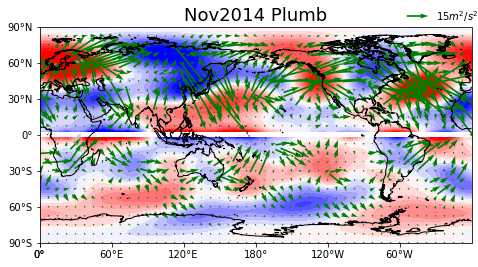

In [72]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.mpl.ticker as cticker

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (0,390,-90,90)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.8, 0.5, 0.5],projection = proj)
ax.set_title('Nov2014 Plumb',loc='center',fontsize=18)

ax.set_extent(img_extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.array([0,60,120,180,240,300,360]), crs=ccrs.PlateCarree())
ax.set_yticks(np.array([-90,-60,-30,0,30,60,90]), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
c1 = ax.contourf(lonc,lat, psic/1e06, zorder=0,levels =np.arange(-2,2.2,0.2) , 
                     extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)

q1 = ax.quiver(lonc[::3],lat[::3], fxc[::3,::3], fyc[::3,::3] ,pivot='mid',
                   scale = 300,color='g',width=0.0038,headwidth=3, transform=ccrs.PlateCarree()) 
ax.quiverkey(q1, X=0.9, Y=1.05, U=15,label=r'$15m^2/s^2$', labelpos='E')

plt.show()

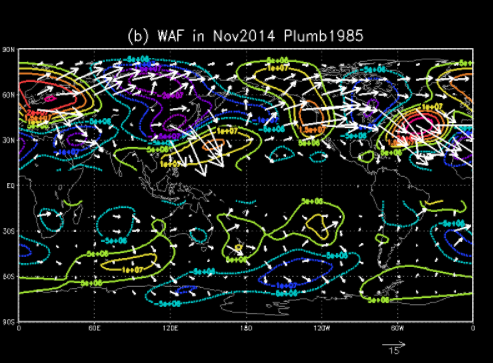

# T advection

## Example by numpy

In [112]:
f_u = xr.open_dataset('/home/mw/input/moyu1828/uwnd.mon.mean.nc')

u = f_u.uwnd.loc['2014-11-01',850,90:0,0:180]

f_v = xr.open_dataset('/home/mw/input/moyu1828/vwnd.mon.mean.nc')
v = f_v.vwnd.loc['2014-11-01',850,90:0,0:180]

f_t = xr.open_dataset('/home/mw/input/moyu1828/air.mon.mean.nc')
t = f_t.air.loc['2014-11-01',850,90:0,0:180]

lon = u.lon
lat = u.lat

In [133]:
dlon=(np.gradient(lon)*np.pi/180.0).reshape((1,lon.shape[0]))
dlat=(np.gradient(lat)*np.pi/180.0).reshape((lat.shape[0],1))
coslat = (np.cos(np.array(lat)*np.pi/180)).reshape((lat.shape[0],1))

a=6370000
dx = a*coslat*dlon
dy = a*dlat

In [134]:
temadvection = -(u * np.gradient(np.array(t),axis = 1)/dx + v * np.gradient(np.array(t),axis = 0)/dy)

/home/moyu/miniconda3/envs/python/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


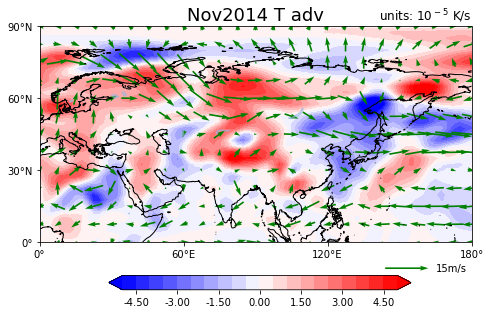

In [135]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.mpl.ticker as cticker

proj = ccrs.PlateCarree(central_longitude=90)
leftlon, rightlon, lowerlat, upperlat = (0,180,0,90)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5],projection = proj)
ax.set_title('Nov2014 T adv',loc='center',fontsize=18)
ax.set_title(r'units: 10$^-$$^5$ K/s',loc='right',fontsize=12)
ax.set_extent(img_extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.array([0,60,120,180]), crs=ccrs.PlateCarree())
ax.set_yticks(np.array([0,30,60,90]), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

c1 = ax.contourf(lon,lat, temadvection/1e-05, zorder=0,levels =np.arange(-5,5.5,0.5) , 
                     extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
q1 = ax.quiver(lon[::3],lat[::3], u.values[::3,::3], v.values[::3,::3] ,pivot='mid',
                   scale = 150,color='g',width=0.0038,headwidth=3, transform=ccrs.PlateCarree()) 
ax.quiverkey(q1, X=0.9, Y=-0.12, U=15,label='15m/s', labelpos='E')
position=fig.add_axes([0.18, 0.08,  0.35, 0.025])
fig.colorbar(c1,cax=position,orientation='horizontal',format='%.2f',)
plt.show()

## Example by metpy

In [3]:
import xarray as xr
from metpy import units
import metpy.calc as mpcalc

In [4]:
f_u = xr.open_dataset('/home/mw/input/moyu1828/uwnd.mon.mean.nc')

u = f_u.uwnd.loc['2014-11-01',850,90:0,0:180]

f_v = xr.open_dataset('/home/mw/input/moyu1828/vwnd.mon.mean.nc')
v = f_v.vwnd.loc['2014-11-01',850,90:0,0:180]

f_t = xr.open_dataset('/home/mw/input/moyu1828/air.mon.mean.nc')
t = f_t.air.loc['2014-11-01',850,90:0,0:180]

lon = u.lon
lat = u.lat

In [131]:
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
temadvection = mpcalc.advection(t,u=u,v=v,dx=dx, dy=dy, x_dim=-1, y_dim=-2)

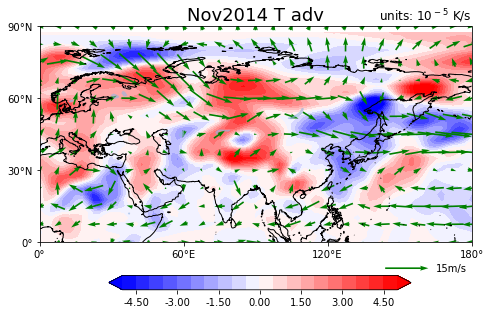

In [132]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.mpl.ticker as cticker

proj = ccrs.PlateCarree(central_longitude=90)
leftlon, rightlon, lowerlat, upperlat = (0,180,0,90)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5],projection = proj)
ax.set_title('Nov2014 T adv',loc='center',fontsize=18)
ax.set_title(r'units: 10$^-$$^5$ K/s',loc='right',fontsize=12)
ax.set_extent(img_extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.array([0,60,120,180]), crs=ccrs.PlateCarree())
ax.set_yticks(np.array([0,30,60,90]), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

c1 = ax.contourf(lon,lat, temadvection/1e-05, zorder=0,levels =np.arange(-5,5.5,0.5) , 
                     extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
q1 = ax.quiver(lon[::3],lat[::3], u.values[::3,::3], v.values[::3,::3] ,pivot='mid',
                   scale = 150,color='g',width=0.0038,headwidth=3, transform=ccrs.PlateCarree()) 
ax.quiverkey(q1, X=0.9, Y=-0.12, U=15,label='15m/s', labelpos='E')
position=fig.add_axes([0.18, 0.08,  0.35, 0.025])
fig.colorbar(c1,cax=position,orientation='horizontal',format='%.2f',)
plt.show()